## Analyzing basic statistics of "ShapeTalk"
#### E.g., 
- number of distinct objects per shape class
- utterances collected for hard vs. easy communication contexts


#### Some Notes: 
    
Basic Lingo: 

1. **Communication Context** =  A pair of objects. One acting as the "target" and one as the "distractor". We also refer sometimes to the distractor as the "source" object. 
    
2. **Annotator** = A person creating referential language to separate the target from the distractor in a given communication context.

Plese see [README](https://github.com/optas/changeit3d/blob/main/assets/README_shapetalk.md) for a more detailed explanation.

In [1]:
import pandas as pd
from ast import literal_eval
from collections import Counter
from termcolor import colored
from changeit3d.utils.visualization import visualize_src_trg_df_at_loc_i

%load_ext autoreload
%autoreload 2

In [6]:
### Use the **downloaded** ShapeTalk data and point to **_YOUR_** underlying directories:
top_img_dir = '../../../data/shapetalk/images/full_size/'
shapetalk_file =  '../../../data/shapetalk/language/shapetalk_preprocessed_public_version_0.csv'

In [7]:
df = pd.read_csv(shapetalk_file)
print('Total collected entries/utterances', colored(len(df), 'red'))
print('Distinct workers:', colored(len(df.workerid.unique()), 'red'))

Total collected entries/utterances 536596
Distinct workers: 2161


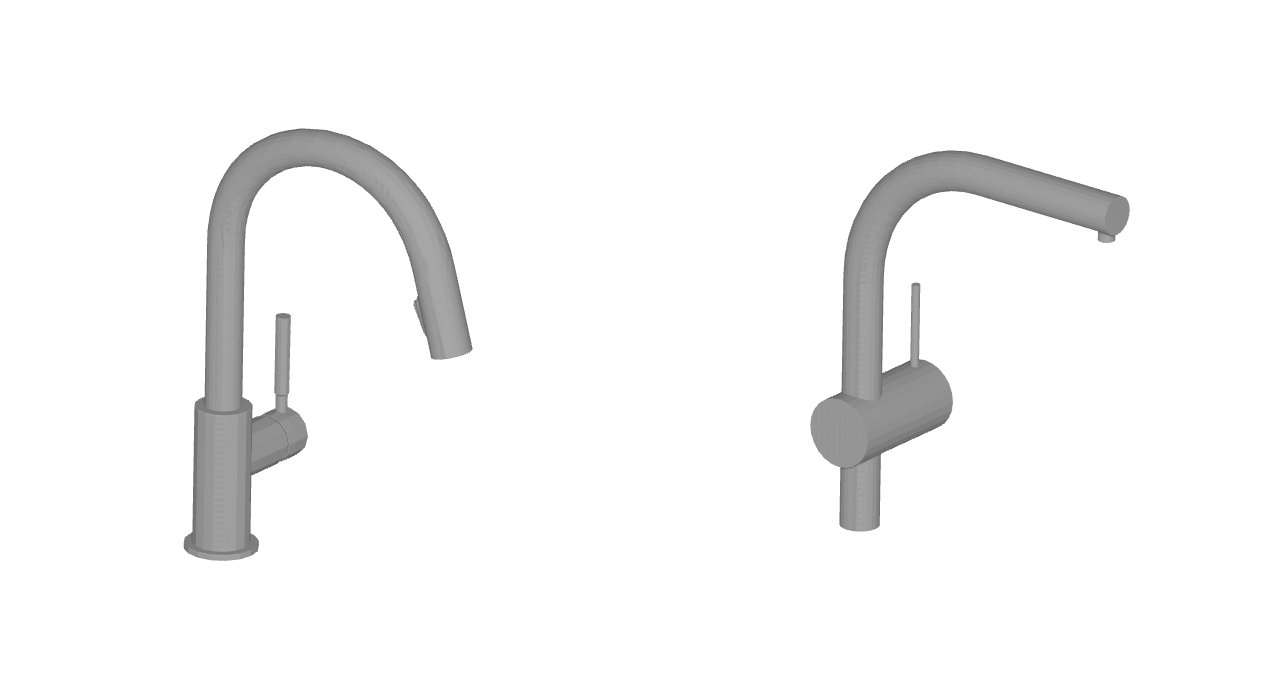

3YZ8UPK3VVFAZDXQF9IWA7EF7IOUCT
utterance0:
Original: The front of the target's spout does not droop downward,
Spelled: the front of the target 's spout does not droop downward


In [8]:
rid = 10
visualize_src_trg_df_at_loc_i(df, rid, top_img_dir=top_img_dir)

In [5]:
printout_latex = False
context = ['source_uid', 'target_uid'] # basic communication context

In [6]:
g = df.groupby(context)
statistic = colored(len(g), 'red')
print(f'Number of distinct communication contexts in ShapeTalk: {statistic}')

statistic = colored(g.utterance.apply(len).mean().round(2), 'red')
print(f'Average number of utterances per communication context (considering different annotators of the same context as one) {statistic}')

g = df.groupby('assignmentid') # i.e., group by (all) the answers given by a signle (any) annotator for a given context
statistic = colored(g.size().mean().round(2), 'red')
print(f'Average number of utterances collected per annotator, per communication context {statistic}')

Number of distinct communication contexts in ShapeTalk: 73799
Average number of utterances per communication context (considering different annotators of the same context as one) 7.27
Average number of utterances collected per annotator, per communication context 4.12


In [7]:
print('Train/Test/Val Splits for ChangeIt3D')
print(df.groupby('changeit_split').apply(len))

print('---')
print("Train/Test/Val Splits for AE networks and other `unary` (single-source-input) networks:")
for val in ['test', 'train', 'val']:
    targets = df.target_uid[df.target_unary_split == val].unique()
    distractors = df.source_uid[df.source_unary_split == val].unique()
    print(val, len(set(targets).union(set(distractors))))
    
print('---')
print('Train/Test/Val Splits for Neural Listening')
print(df.groupby('listening_split').apply(len))

print('---\n')
unique_contexts_for_listening = len((df[df.listening_split == 'test']).groupby(context))
print("Number of Unique Contexts for neural listening (test)", unique_contexts_for_listening)

Train/Test/Val Splits for ChangeIt3D
changeit_split
ignore      3525
rest       46787
test       53341
train     408810
val        24133
dtype: int64
---
Train/Test/Val Splits for AE networks and other `unary` (single-source-input) networks:
test 3637
train 30915
val 1839
---
Train/Test/Val Splits for Neural Listening
listening_split
ignore      3858
test       53341
train     452502
val        26895
dtype: int64
---

Number of Unique Contexts for neural listening (test) 7407


# Language-oriented Analysis (basics)

In [8]:
df.tokens = df.tokens.apply(literal_eval)

all_tokens = Counter()
df.tokens.apply(lambda x: all_tokens.update(x))
print('Number of unique tokens:', colored(len(all_tokens), 'red'))

# some assertions
assert (df.tokens.apply(lambda x: ' '.join(x)) == df.utterance_spelled).all(), "tokens are not spelled"
assert not df.hard_context.isna().any(), "not all contexts have a hard/easy label"

Number of unique tokens: 9250


In [9]:
statistic = colored(df.hard_context.mean().round(3) * 100, 'red')
print('Percent of utterances from hard contexts:', statistic)

g = df.groupby(context)
statistic = g.hard_context.apply(lambda x: x.iloc[0]).mean().round(3) * 100
statistic = colored(statistic, 'red')
print('Percent of contexts that are hard:', statistic)

Percent of utterances from hard contexts: 49.5
Percent of contexts that are hard: 48.6


In [10]:
for w in ['target', 'distractor']:
    print(f'Number of utterances where the word {w} is explicitly mentioned:', df.utterance_spelled.apply(lambda x: w in x).sum())

Number of utterances where the word target is explicitly mentioned: 121785
Number of utterances where the word distractor is explicitly mentioned: 7540


In [11]:
ignore_tokens = set(['-er', '-est'])
avg_tokens = df['tokens'].apply(lambda x: len([i for i in x if i not in ignore_tokens])).mean()
hard_avg_tokens = df['tokens'][df.hard_context ].apply(lambda x: len([i for i in x if i not in ignore_tokens])).mean()
easy_avg_tokens = df['tokens'][~df.hard_context].apply(lambda x: len([i for i in x if i not in ignore_tokens])).mean()

print("Average tokens per utterance",  colored(avg_tokens.round(2), 'red'))
print("Average tokens per utterance in hard contexts", colored(hard_avg_tokens.round(2), 'red'))
print("Average tokens per utterance in easy contexts", colored(easy_avg_tokens.round(2), 'red')) 

Average tokens per utterance 6.28
Average tokens per utterance in hard contexts 6.49
Average tokens per utterance in easy contexts 6.08


In [12]:
# Compute per-class statistics

compute_is_hard_prc = True    # hard contexts per class

latex_df = []
ignore_tokens = set(['-er', '-est'])
shape_class_to_avg_tokens = dict()    

for c in sorted(df.source_object_class.unique()):
    mask = df.source_object_class == c
    avg_tokens = df[mask]['tokens'].apply(lambda x: len([i for i in x if i not in ignore_tokens])).mean()
    # print("{:20s}{:10d}{:20f}".format(c, mask.sum(), avg_tokens))
    shape_class_to_avg_tokens[c] = avg_tokens    
    per_class_row = [c.capitalize(),  "{:.1f}".format(avg_tokens)]    
    if compute_is_hard_prc:                 
        per_class_row.append("{:.1f}".format(df[mask].hard_context.mean() * 100))    
    latex_df.append(per_class_row)
    
    
if True:    
    row = ['Weighted Average',
     "{:.1f}".format(df['tokens'].apply(lambda x: len([i for i in x if i not in ignore_tokens])).mean())
    ]
    
    header = ['Class', '(avg) Number Tokens']
    
    if compute_is_hard_prc:
        row.append("{:.1f}".format(df.hard_context.mean()  * 100 ))
        header.append('Hardness Prc.')
    
    
    latex_df.append(row)
    latex_df = pd.DataFrame(latex_df, columns=header)

df['avg_class_tokens'] = df.source_object_class.apply(lambda x: shape_class_to_avg_tokens[x])
    
print(latex_df.to_markdown())

|    | Class            |   (avg) Number Tokens |   Hardness Prc. |
|---:|:-----------------|----------------------:|----------------:|
|  0 | Airplane         |                   6.8 |            50.2 |
|  1 | Bag              |                   6.6 |            50   |
|  2 | Bathtub          |                   6.4 |            49.4 |
|  3 | Bed              |                   5.5 |            49.9 |
|  4 | Bench            |                   5.8 |            48.1 |
|  5 | Bookshelf        |                   5.9 |            49.5 |
|  6 | Bottle           |                   6.7 |            50   |
|  7 | Bowl             |                   7.2 |            49.9 |
|  8 | Cabinet          |                   5.8 |            49   |
|  9 | Cap              |                   6.4 |            49.9 |
| 10 | Chair            |                   6.6 |            49   |
| 11 | Clock            |                   6.1 |            49.8 |
| 12 | Display          |                   6.6 

In [13]:
## Print volume statistics per class. 
classes_covered = df.source_object_class.unique()
latex_df = []

total_b = total_c = total_d = 0

for name, g in df.groupby('source_object_class'):        
    
    unique_shapes = set(g.source_uid.unique()).union(set(g.target_uid.unique()))
    
    a, b, c, d = name, len(unique_shapes), len(g.assignmentid.unique()), len(g)
    total_b += b
    total_c += c    
    total_d += d
            
    latex_df.append([a.capitalize(),  "{:,}".format(b),  "{:,}".format(c),  "{:,}".format(d)])

latex_df.append(['Total', "{:,}".format(total_b), "{:,}".format(total_c),  "{:,}".format(total_d)])    
latex_df = pd.DataFrame(latex_df, columns=['Class', 'Unique Shapes', 'Unique Submissions', 'Utterances'])
# print(latex_df.to_latex(index=False))
print(latex_df.to_markdown(index=False))

| Class      | Unique Shapes   | Unique Submissions   | Utterances   |
|:-----------|:----------------|:---------------------|:-------------|
| Airplane   | 2,722           | 11,130               | 44,450       |
| Bag        | 139             | 834                  | 3,327        |
| Bathtub    | 664             | 3,073                | 12,093       |
| Bed        | 747             | 2,985                | 14,870       |
| Bench      | 1,657           | 6,633                | 25,617       |
| Bookshelf  | 816             | 3,263                | 16,114       |
| Bottle     | 492             | 1,968                | 5,897        |
| Bowl       | 232             | 928                  | 2,776        |
| Cabinet    | 246             | 984                  | 3,860        |
| Cap        | 208             | 1,263                | 3,775        |
| Chair      | 6,608           | 15,225               | 74,812       |
| Clock      | 580             | 2,320                | 9,231        |
| Disp

In [14]:
ignore_tokens = set(['-er', '-est', 'target', 'distractor']) # people tend to say target at first sents. more than the end
print("utterance (saliency), #utterances, n-tokens, n-tokens-normalized")
for s in range(df.saliency.max() + 1):
    mask = df.saliency == s
    
    tokens_per_saliency = df[mask]['tokens'].apply(lambda x: len([i for i in x if i not in ignore_tokens]))
    avg_tokens_per_saliency = tokens_per_saliency.mean().round(2)
    
    normalizer = df[mask]['avg_class_tokens']  # not all classes where asked to be described with 5 utterances
    avg_tokens_per_saliency_class_normalized = (tokens_per_saliency / normalizer).mean().round(2)
        
    print(f'{s}:', mask.sum(), avg_tokens_per_saliency, avg_tokens_per_saliency_class_normalized)

print("In other words, the uttterances become longer when they describe less salient/obvious differences.")

utterance (saliency), #utterances, n-tokens, n-tokens-normalized
0: 130342 5.69 0.9
1: 130045 5.96 0.95
2: 129324 6.17 0.98
3: 114560 6.32 1.01
4: 32325 6.29 1.02
In other words, the uttterances become longer when they describe less salient/obvious differences.


In [15]:
all_shapes = set()
for tag in ['source', 'target']:
    shapes = df.groupby([f'{tag}_model_name', f'{tag}_dataset', f'{tag}_object_class'])
    shapes = set(list(shapes.groups.keys()))    
    print('unique shapes used as', colored(f'{tag}, {len(shapes)}', 'red'))
    all_shapes.update(shapes)
print('all', len(all_shapes))

unique shapes used as source, 29313
unique shapes used as target, 36391
all 36391


In [16]:
print('Assert that all shapes used as Distractors have also been considered as Targets')

for c in classes_covered:
    ndf = df[df.target_object_class == c].copy()
    
    tag = 'target'
    target_shapes =  ndf.groupby([f'{tag}_model_name', f'{tag}_dataset', f'{tag}_object_class'])
    target_shapes = set(list(target_shapes.groups.keys()))    
    
    tag = 'source'
    source_shapes =  ndf.groupby([f'{tag}_model_name', f'{tag}_dataset', f'{tag}_object_class'])
    source_shapes = set(list(source_shapes.groups.keys()))    
    
    sources_not_used_as_targets = source_shapes.difference(target_shapes)
    assert(len(sources_not_used_as_targets) == 0)    

Assert that all shapes used as Distractors have also been considered as Targets


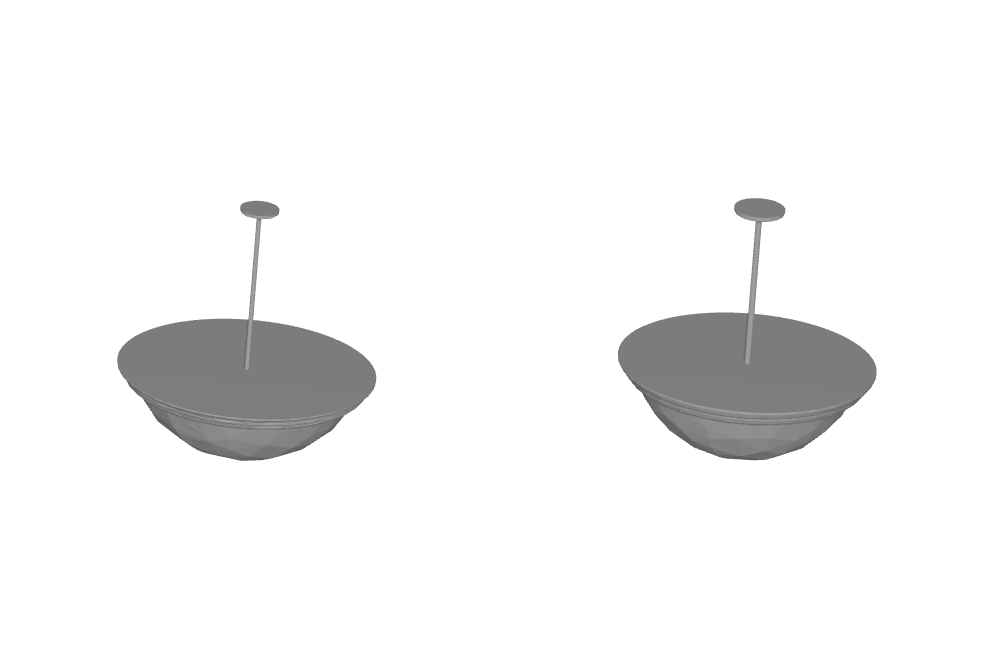

3KRVW3HTZPE7TMHD3THAY213CSEMSC
utterance1:
Original: Target appears to have a slightly taller lampshade
Spelled: target appears to have a slightly tall -er lampshade


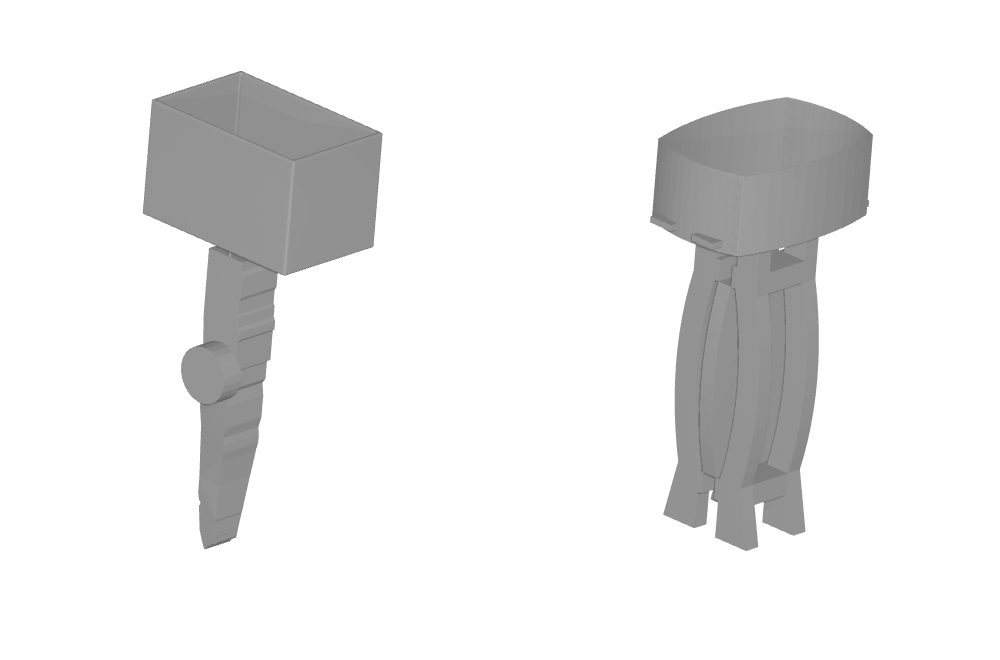

3H0W84IWBMVXGJPN76TMVKRXBX4REE
utterance0:
Original: the shade is ridged
Spelled: the shade is ridged


In [32]:
## Visualize random examples that are hard vs. easy in a given class
class_to_comp = "lamp"
hard_loc = df[(df.hard_context) & (df.source_object_class == class_to_comp)].sample().index[0]
easy_loc = df[(~df.hard_context) & (df.source_object_class == class_to_comp)].sample().index[0]
visualize_src_trg_df_at_loc_i(df, hard_loc, top_img_dir=top_img_dir)
visualize_src_trg_df_at_loc_i(df, easy_loc, top_img_dir=top_img_dir)